# Pre-earnings straddle
The goal of this section is to indescriminantly test a pre-earnings staddle. We will be testing the strategy over the last six years (01/01/12 - 01/01/18) on the composite DOW 30 + NASDAQ 100. The choice of the backtesting window and index are due in part to generality and in part to testing claims made by CMLviz about this data set. We find that a pre-earnings straddle is in fact a winning strategy over this time period with average returns of +2% per straddle. The backtest results for different fixed bets and distribution of returns are shown below.

## First, upload trades

In [1]:
import pandas as pd
import glob
import numpy as np
import time
import json

    
# Make a dict with the NASDAQ 100 + DOW 30 composite index for each year
years = [2012,2013,2014,2015,2016,2017]
symbol_lookup = pd.read_csv('../SYMBOL_LOOKUP.csv')  # helps convert between tickers and company names
index_dict = {}
for year in years:
    filename = '../Annual_Index/'+str(year)+'_index.csv'
    annual_index = pd.read_csv(filename,names=['Company','Exchange'])
    annual_index['Ticker'] = annual_index['Company']
    # match the ticker
    for i in annual_index.index:
        annual_index['Ticker'][i] = symbol_lookup[symbol_lookup['Company']==annual_index['Company'][i]]['Ticker'].values[0]
    index_dict[year] = np.unique(annual_index['Ticker'].values).tolist()
    
# save the index dictionary to file
with open('annual_index.json', 'w') as fp:
    json.dump(index_dict, fp) 
    
    
# Next we need to import all of the downloaded trade data
all_files = glob.glob('../Downloads/Downloads_*/'+'*.csv')
df = pd.DataFrame() # Dataframe to store all downloads
all_data = []
symbols = []  # keeps track of which tickers we already downloaded
print("Importing data...")
for file in all_files:
    data = pd.read_csv(file,index_col=None, header=0)
    if len(data['Symbol']) != 0:
        ticker = data['Symbol'][0]
#         print("Ticker = ",ticker)
        if ticker not in symbols:
            all_data.append(data)
            symbols.append(ticker)
        else:
            print("\tDuplicate Download for "+ticker)
    else:
        print("\tEmpty File: ",file)
print("Import finished.")
        
df = pd.concat(all_data)  # this is our dataframe with all the trades
df.index = range(len(df))

close_statements = ['Close 1DaysBeforeEarnings:Long Calls','Close 1DaysBeforeEarnings:Long Puts',\
                   'Close -40%CloseAfterLosses:Long Calls','Close -40%CloseAfterLosses:Long Puts',\
                   'Close 40%CloseAfterGains:Long Calls','Close 40%CloseAfterGains:Long Puts']
open_statements = ['Open 7DaysBeforeEarnings:Long Calls','Open 7DaysBeforeEarnings:Long Puts']

# Add a column with the year the trade was opened
year_list = []
for i in df.index:
    if df['Description'][i] in open_statements:
        date = df['Date'][i]
        striptime = time.strptime(date,"%d-%b-%M")  # parse year using %M (minute) format
        year = striptime.tm_min
        year_list.append('20'+str(year))
    # If trade closes, make sure it didn't open the previous year
    elif df['Description'][i] in close_statements:
        # go back to most recent open statement
        counter = 1
        while counter <= 2:
            description = df['Description'][i-counter]
            if description in open_statements:
                open_date = df['Date'][i-counter]
                striptime = time.strptime(open_date,"%d-%b-%M")  # parse year using %M (minute) format
                year = striptime.tm_min
                year_list.append('20'+str(year))
                break
            else:
                counter = counter + 1
        if counter == 3:
            print("ERROR - COULD NOT PAIR STRADDLE CLOSE WITH STRADDLE OPEN")
            break
    else:
        print("ERROR - NO MATCHING DESCRIPTION",df['Description'][i])

        
df['Year'] = year_list # add column

# Sort by datetime and reindex
df['Date'] = pd.to_datetime(df.Date)
df = df.sort_values('Date')
df.index = range(len(df))

# Convert trade prices to float
value_list = []
for i in df.index:
    value = float(df['Trade Price'][i].replace('$',''))
    value_list.append(value)    
df['Trade Price'] = value_list

# Remove any companies that weren't part of the index that year
print("\nChecking data...")
with open("../errors.txt","r") as f:
    error_dict = json.load(f) # companies known to have missing data
flag = 0
for year in years:
    bad_indices = []  # list to hold index of trades that shouldn't be included
    annual_df = df[df['Year']==str(year)]
    for i in annual_df.index:
        if annual_df['Symbol'][i] not in index_dict[year]:
            bad_indices.append(i)
    
    df = df.drop(bad_indices)
    
    # Check that we have accounted for all the data
    print("Obtained data for ",len(np.unique(df[df['Year']==str(year)]['Symbol'])),"out of ",len(index_dict[year]),"companies in ",year)
    for i in index_dict[year]:
        if i not in np.unique(df[df['Year']==str(year)]['Symbol']):
            if i in error_dict.keys():
                print("\tMissing download for company ",i, "in",year)
                print("\t\tReason: ",error_dict[i])
            else:
                print("ERROR - No downloads found for ",i)
                flag = 1
if flag == 0:
    print("\nAll companies in index accounted for. Good to proceed.")
else:
    print("\nWARNING - unaccounted for companies in index.")

# Reindex and export to csv
output_file = 'all_trades.csv'
print("\nWriting file to ",output_file)
df.index = range(len(df))
df.to_csv(output_file)
print("Done")

Importing data...
	Empty File:  ../Downloads/Downloads_1/CML TM Trades Buy 50 Delta Call, Buy 50 Delta Put 20181022 (9).csv
	Duplicate Download for AVGO
Import finished.

Checking data...
Obtained data for  110 out of  127 companies in  2012
	Missing download for company  ALTR in 2012
		Reason:  acquired by intel - ticker invalid.
	Missing download for company  BMC in 2012
		Reason:  went private in 2013
	Missing download for company  BRCM in 2012
		Reason:  overtook by avago in 2016 - ticker retired.
	Missing download for company  CTRX in 2012
		Reason:  acquired by OptumRX in 2015
	Missing download for company  DELL in 2012
		Reason:  went private 2013 (largest tech buyout ever)
	Missing download for company  DTV in 2012
		Reason:  acquired by AT&T in 2015
	Missing download for company  DWDP in 2012
		Reason:  Could not download data for DuPont prior to merger
	Missing download for company  LIFE in 2012
		Reason:  boughtout in 2014 brand retired in 2015
	Missing download for company 

## Run Backtest

In [13]:
import pandas as pd
import numpy as np
import json
import pickle


# Read in data
df = pd.read_csv('all_trades.csv',index_col=0)  # all trades for all companies

initial_capital = 10e6  # start with 10M
capital = initial_capital
bets = {'1K':1000,'10K':1e4,'100K':1e5,'300K':3e5} # betting strategy
running_capital ={'1K':[capital],'10K':[capital],'100K':[capital],'300K':[capital]} # portfolio value for each strategy
open_bets ={'1K':[],'10K':[],'100K':[],'300K':[]} # holds the open bets for each strategy
time = {'1K':[df['Date'][0]],'10K':[df['Date'][0]],'100K':[df['Date'][0]],'300K':[df['Date'][0]]} # portfolio value for each strategy

# Loop over trades and keep track of money
open_calls = {}
open_puts = {}
open_straddles = {}  # if you have an open call and open put you have an open straddle
results = {k: [] for k in np.unique(df['Symbol'])} # dict to store the open and close price of all straddles

# Run backtest on straddles
print("Starting Backtest...")
print("Initial Capital = $",int(initial_capital))
print("Strategies = ")
for strategy in bets.keys():
    print("\t",strategy,"fixed bet.")
print("\n")

flag = 0 # catch errors
N_greater_than_40 = 0
N_less_than_40 = 0
N_max_caught = 0
N_min_caught = 0
for i in df.index:
    
    # Open call and store price
    if df['Description'][i] == 'Open 7DaysBeforeEarnings:Long Calls':
        open_calls[df['Symbol'][i]] = df['Trade Price'][i]
#         print(df['Date'][i],":",df['Symbol'][i]," call opened for ",df['Trade Price'][i])
        
        # Did this open the straddle?
        if df['Symbol'][i] in open_puts.keys():
            open_straddles[df['Symbol'][i]] = [open_puts[df['Symbol'][i]] + open_calls[df['Symbol'][i]]]
#             print(df['Date'][i],":",df['Symbol'][i]," STRADDLE OPENED AT ",open_straddles[df['Symbol'][i]][0])
        
            # Update our capital
            for strategy in running_capital.keys():
                index = len(running_capital[strategy]) # time series index
                capital = running_capital[strategy][index-1] # current capital
                bet = bets[strategy]
                time[strategy].append(df['Date'][i]) # store date
                if capital - bet >= 0.:
#                     print("\tBET($) = ",bet,"ON STRATEGY",strategy)
                    running_capital[strategy].append(round(capital-bet,2))  # subtract cost of bet
                    open_bets[strategy].append(df['Symbol'][i])
                else:
#                     print("\tUNABLE TO AFFORD ",strategy," BET")
                    running_capital[strategy].append(round(capital,2))
        
    # Open put and store price
    elif df['Description'][i] == 'Open 7DaysBeforeEarnings:Long Puts':
        open_puts[df['Symbol'][i]] = df['Trade Price'][i]
#         print(df['Date'][i],":",df['Symbol'][i]," put opened for ",df['Trade Price'][i])
        
        # Did this open the straddle?
        if df['Symbol'][i] in open_calls.keys():
            open_straddles[df['Symbol'][i]] = [open_puts[df['Symbol'][i]] + open_calls[df['Symbol'][i]]]
#             print(df['Date'][i],":",df['Symbol'][i]," STRADDLE OPENED AT ",open_straddles[df['Symbol'][i]][0])
            
            # Update our capital
            for strategy in running_capital.keys():
                index = len(running_capital[strategy]) # time series index
                capital = running_capital[strategy][index-1] # current capital
                bet = bets[strategy]
                time[strategy].append(df['Date'][i]) # store date
                if capital - bet >= 0.:
#                     print("\tBET($) = ",bet,"ON STRATEGY",strategy)
                    running_capital[strategy].append(round(capital-bet,2))  # subtract cost of bet
                    open_bets[strategy].append(df['Symbol'][i])
                else:
#                     print("\tUNABLE TO AFFORD ",strategy," BET")
                    running_capital[strategy].append(round(capital,2))
        
    # Close call and store percent change
    elif df['Description'][i] == 'Close 1DaysBeforeEarnings:Long Calls' or \
    df['Description'][i] == 'Close 40%CloseAfterGains:Long Calls' or \
    df['Description'][i] =='Close -40%CloseAfterLosses:Long Calls':
        closing_price = df['Trade Price'][i]
        opening_price = open_calls[df['Symbol'][i]]
        open_calls.pop(df['Symbol'][i], None) # close call
#         print(df['Date'][i],":",df['Symbol'][i]," call closed for ",df['Trade Price'][i])
        open_straddles[df['Symbol'][i]].append(closing_price-opening_price) # append change in call price to open_straddle
        
        # Did this close the straddle?
        if df['Symbol'][i] not in open_puts.keys():
            opening_price = open_straddles[df['Symbol'][i]][0]
            closing_price = np.sum(open_straddles[df['Symbol'][i]])
            percent_change = (closing_price-opening_price)/opening_price
            results[df['Symbol'][i]].append([opening_price,closing_price])
#             print(df['Date'][i],":",df['Symbol'][i]," STRADDLE CLOSED AT ",closing_price)
#             print("\t GAIN/LOSS(%) = ",percent_change)
            open_straddles.pop(df['Symbol'][i], None) # close straddle
            
            # Update our capital if we placed the bet
            for strategy in running_capital.keys():
                index = len(running_capital[strategy]) # time series index
                capital = running_capital[strategy][index-1] # current capital                
                bet = bets[strategy]
                if df['Symbol'][i] in open_bets[strategy]:
                    capital = capital+bet*(1+percent_change) # new capital
                    open_bets[strategy].remove(df['Symbol'][i]) # close bet 
                running_capital[strategy].append(round(capital,2))  # subtract cost of bet
                time[strategy].append(df['Date'][i])
                
            # Lets count how many straddles actually closed when the limit was met vs how many limits were met
            if percent_change >= 0.4:
                N_greater_than_40 = N_greater_than_40 + 1
            if percent_change <= -0.4:
                N_less_than_40 = N_less_than_40 + 1

            if df['Description'][i] == 'Close 40%CloseAfterGains:Long Calls':
                N_max_caught = N_max_caught + 1
            if df['Description'][i] =='Close -40%CloseAfterLosses:Long Calls':
                N_min_caught = N_min_caught + 1        
        
        
    # Close put and store percent change
    elif df['Description'][i] == 'Close 1DaysBeforeEarnings:Long Puts' or \
    df['Description'][i] == 'Close 40%CloseAfterGains:Long Puts' or \
    df['Description'][i] =='Close -40%CloseAfterLosses:Long Puts':
        closing_price = df['Trade Price'][i]
        opening_price = open_puts[df['Symbol'][i]]
        open_straddles[df['Symbol'][i]].append(closing_price-opening_price) # append change in put price to open_straddle
        open_puts.pop(df['Symbol'][i], None) # close put
#         print(df['Date'][i],":",df['Symbol'][i]," put closed for ",df['Trade Price'][i])
        
        # Did this close the straddle?
        if df['Symbol'][i] not in open_calls.keys():
            opening_price = open_straddles[df['Symbol'][i]][0]
            closing_price = np.sum(open_straddles[df['Symbol'][i]])
            percent_change = (closing_price-opening_price)/opening_price
            results[df['Symbol'][i]].append([opening_price,closing_price])
#             print(df['Date'][i],":",df['Symbol'][i]," STRADDLE CLOSED AT ",closing_price)
#             print("\t GAIN/LOSS(%) = ",percent_change)
            open_straddles.pop(df['Symbol'][i], None) # close straddle
            
            # Update our capital if we placed the bet
            for strategy in running_capital.keys():
                index = len(running_capital[strategy]) # time series index
                capital = running_capital[strategy][index-1] # current capital                
                bet = bets[strategy]
                if df['Symbol'][i] in open_bets[strategy]:
                    capital = capital+bet*(1+percent_change) # new capital
                    open_bets[strategy].remove(df['Symbol'][i]) # close bet 
                running_capital[strategy].append(round(capital,2))  # subtract cost of bet
                time[strategy].append(df['Date'][i])
            
            # Lets count how many straddles actually closed when the limit was met vs how many limits were met
            if percent_change >= 0.4:
                N_greater_than_40 = N_greater_than_40 + 1
            if percent_change <= -0.4:
                N_less_than_40 = N_less_than_40 + 1

            if df['Description'][i] == 'Close 40%CloseAfterGains:Long Calls':
                N_max_caught = N_max_caught + 1
            if df['Description'][i] =='Close -40%CloseAfterLosses:Long Calls':
                N_min_caught = N_min_caught + 1        
            
    else:
        print("ERROR!!! NO MATCHING DESCRIPTION",df['Description'][i])
        flag = 1
        break


# Write the results dict to a file
with open('straddle_results.pkl', 'wb') as fp:
    pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Write the time series to a json
ts_df = pd.DataFrame(
    {
        'Date':time['1K'],
        '1K':running_capital['1K'],
        '10K':running_capital['10K'],
        '100K':running_capital['100K'],
        '300K':running_capital['300K']
    }
)

# Set negative value to zeros
pd.options.mode.chained_assignment = None  # turn off warning about chained assignments
for column in ts_df.columns[1:]:
    array = ts_df[column]
    for i in array.index:
        if ts_df[column][i] < 0:
            print("Portfolio went negative for ",column," strategy")
            ts_df[column][i:] = 0.
            break
            
ts_df.to_pickle('time_series.pkl')  # save dataframe as pickle
    
if flag == 0:
    print("\nBacktest Complete")
    for strategy in running_capital.keys():
        print("Strategy = ",strategy," Fixed Bet")
        print("\tInitial Capital = ",initial_capital)
        final_capital = ts_df[strategy].iloc[-1]
        print("\tFinal Capital = ",final_capital)
        print("\tPercent Change = ",round((final_capital-initial_capital)/initial_capital,6)*100,"%")
    
    

Starting Backtest...
Initial Capital = $ 10000000
Strategies = 
	 1K fixed bet.
	 10K fixed bet.
	 100K fixed bet.
	 300K fixed bet.



Backtest Complete
Strategy =  1K  Fixed Bet
	Initial Capital =  10000000.0
	Final Capital =  10060362.89
	Percent Change =  0.6035999999999999 %
Strategy =  10K  Fixed Bet
	Initial Capital =  10000000.0
	Final Capital =  10603628.54
	Percent Change =  6.0363 %
Strategy =  100K  Fixed Bet
	Initial Capital =  10000000.0
	Final Capital =  16036284.18
	Percent Change =  60.36280000000001 %
Strategy =  300K  Fixed Bet
	Initial Capital =  10000000.0
	Final Capital =  27647016.77
	Percent Change =  176.4702 %


#### How well did we catch +/- 40% returns?

In [3]:
print("Caught",N_max_caught,"out of ",N_greater_than_40,"returns > 40%")
print("Caught",N_min_caught,"out of ",N_less_than_40,"returns < -40%")

Caught 49 out of  165 returns > 40%
Caught 3 out of  8 returns < -40%


## Plot the Distribution of Returns

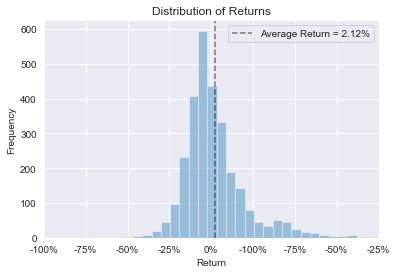

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
sns.set_style('darkgrid')
%matplotlib inline

# Read in the results dict from file
with open('straddle_results.pkl', 'rb') as fp:
    results = pickle.load(fp)    
    
return_percentage = []
for company in results.keys():
    for straddle in results[company]:
        initial_value = straddle[0]
        final_value = straddle[1]
        percent_diff = (final_value-initial_value)/initial_value*100
#         if percent_diff > 40.:
#             percent_diff = 40.
#         if percent_diff < -40:
#             percent_diff = -40
        return_percentage.append(percent_diff)
        
sns.distplot(return_percentage,kde=False)
plt.axvline(np.mean(return_percentage),color='k',linestyle='--',alpha=0.5,label='Average Return = '+str(round(np.mean(return_percentage),2))+"%")
plt.title('Distribution of Returns')
plt.ylabel('Frequency')
plt.xlabel('Return')
plt.xlim((-100,100))
plt.xticks(np.linspace(-100,100,9),['-100%','-75%','-50%','-25%','0%','-100%','-75%','-50%','-25%'])
plt.legend()
#plt.savefig("returns.pdf")
plt.show()

## Plot the Backtest Results

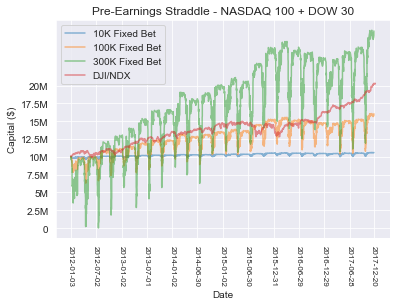

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('darkgrid')
%matplotlib inline

initial_capital = 10e6  # started with 10M

# Read in time series df
ts_df = pd.read_pickle('time_series.pkl')
ts_df['Date'] = pd.to_datetime(ts_df['Date'])
time = ts_df['Date']

# Read in historical data for DOW 30 and NASDAQ 100
DJI = pd.read_csv('../Downloads/DJI.csv')  # DOW 30
NDX = pd.read_csv('../Downloads/DJI.csv')  # NASDAQ 100
DJI['Date'] = pd.to_datetime(DJI['Date']) # convert string to timestamp
NDX['Date'] = pd.to_datetime(NDX['Date'])
DJI['Gain/Loss'] = DJI['Close']/DJI['Open'][0]  # add col for fractional change
NDX['Gain/Loss'] = NDX['Close']/NDX['Open'][0]
DJI['Value'] = DJI['Gain/Loss']*initial_capital # keep track of portfolio value
NDX['Value'] = NDX['Gain/Loss']*initial_capital

# label x_coords
ticks = ['2012-01-03','2012-07-02','2013-01-02','2013-07-01','2014-01-02','2014-06-30','2015-01-02', \
         '2015-06-30','2015-12-31','2016-06-29','2016-12-29','2017-06-28','2017-12-20']

# Plot
for column in ts_df.columns[2:]:
    plt.plot_date(time,ts_df[column],'-',alpha=0.5,label=column+" Fixed Bet")  # plot straddles
plt.plot_date(DJI['Date'],DJI['Value'],'-',alpha=0.5,label='DJI/NDX') # plot historical
# plt.plot_date(NDX['Date'],NDX['Value'],alpha=0.5,markersize=0.1,label='NDX')
plt.xticks(ticks,ticks,rotation=-90,size=8)
#plt.yticks([.6e7,.8e7,1e7,1.2e7,1.4e7,1.6e7],['6M','8M','10M','12M','14M','16M'])
plt.yticks(np.linspace(0,2e7,9),['0','2.5M','5M','7.5M','10M','12.5M','15M','17.5M','20M'])
plt.ylabel('Capital ($)')
plt.title('Pre-Earnings Straddle - NASDAQ 100 + DOW 30')
plt.xlabel('Date')
plt.legend()
#plt.savefig('backtests.pdf',bbox_inches='tight')
plt.show()

## Add marginal pdf to explain oscillations
- Oscillations are due to the large upfront cost of placing many bets at the same time each quarter and having to wait to exercise the strategy. In other words, there is a week between placing the bets and reaping the returns. While the returns do not always bring you back to your original capital, they always give you some return on your investment (hence the monotonic increase following the steep drop of the initial investment). If we don't insist on withdrawing the bet from the account, we will not see these oscillations.

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


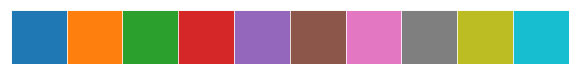

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Get hex code for colors
current_palette = sns.color_palette()
print(current_palette.as_hex())
sns.palplot(current_palette)


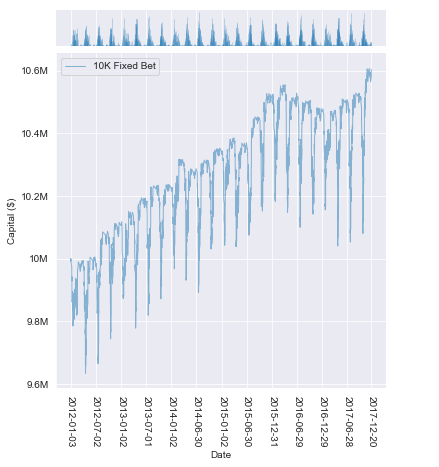

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('darkgrid')
%matplotlib inline

# Read in time series df
ts_df = pd.read_pickle('time_series.pkl')
ts_df['Date'] = pd.to_datetime(ts_df['Date']) # convert string to datetime
ts_df['DateNum'] = pd.to_numeric(ts_df['Date']) # convert datetime to numeric (for seaborn)

# Choose time labels on x-axis 
labels = ['2012-01-03','2012-07-02','2013-01-02','2013-07-01','2014-01-02','2014-06-30','2015-01-02', \
         '2015-06-30','2015-12-31','2016-06-29','2016-12-29','2017-06-28','2017-12-20']
ticks = pd.to_numeric(pd.to_datetime(labels))

# Plot
g = sns.JointGrid(x='DateNum',y='10K',data=ts_df,ratio=8) # initialize jointgrid
g = g.plot_joint(plt.plot,color='#1f77b4',linewidth=1.,alpha=0.5,label='10K Fixed Bet') # scatter plot data
_ = g.ax_marg_x.hist(ts_df["DateNum"], color='#1f77b4',edgecolor='#1f77b4', alpha=0.25,bins=len(ts_df['Date']))
g.ax_joint.set_yticks(np.linspace(9.6e6,1.06e7,6))
g.ax_joint.set_yticklabels(['9.6M','9.8M','10M','10.2M','10.4M','10.6M'])
g.ax_joint.set_xticks(ticks)
g.ax_joint.set_xticklabels(labels,rotation=-90)
g.ax_joint.set_xlabel('Date')
g.ax_joint.set_ylabel('Capital ($)')
g.ax_marg_y.axis('off')
plt.legend()
#plt.savefig('marginals.pdf',bbox_inches='tight')
plt.show()

# Part I - Conclusions
- Pre-earnings straddle is a winning strategy but small bets don't beat the market
- Return percentage is directly proportional to bet size.
- Oscillations are due to upfront cost of bets.

# Part II - Specific Companies
The goal of this section is to look for specific companies that have win percentages drawn from a different distribution than the average. The idea being that pre-earnings straddles may work well for specific companies despite not working well in general. The difficult part is that we cannot be bias by post selection. Since we have analyzed hundreds of companies there will be some with high win percentages due to chance rather than the strategy working in a fundamentally different way. To test this hypothesis, we must identify the distribution that win percentages are drawn from and see if certain companies have abnormally low probabilities of belonging to this distribution. 

## First calculate the win rate

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
sns.set_style('darkgrid')
%matplotlib inline

# Read in the results dict from file
with open('straddle_results.pkl', 'rb') as fp:
    result_dict = pickle.load(fp)   

# Create lists to hold summary
company_list = []
straddle_list = []
win_list = []
tie_list = []
loss_list = []

# Find values
flag = 0 # error flag
for company in result_dict.keys():
    N_straddles = len(result_dict[company])
    N_wins = 0.
    N_ties = 0.
    N_losses = 0.
    for straddle in result_dict[company]:
        if straddle[1] > straddle[0]:
            N_wins = N_wins + 1
        elif straddle[1] == straddle[0]:
            N_ties = N_ties + 1
        elif straddle[1] < straddle[0]:
            N_losses = N_losses+1
        else:
            print("ERROR - NO COMPARISON")
            flag = 1 # throw error
            break
    # break on error
    if flag == 1:
        break
        
    # append results
    company_list.append(company)
    straddle_list.append(N_straddles)
    win_list.append(N_wins)
    tie_list.append(N_ties)
    loss_list.append(N_losses)
    
# Write results to dataframe
result_df = pd.DataFrame(
    {
        'Company':company_list,
        'N_straddles':straddle_list,
        'N_wins':win_list,
        'N_ties':tie_list,
        'N_losses':loss_list
    }
)

# Make sure N_straddles is the sum of N_wins + N_ties + N_losses
for i in result_df.index:
    if result_df['N_straddles'].iloc[i] != result_df['N_wins'].iloc[i]+result_df['N_ties'].iloc[i]+result_df['N_losses'].iloc[i]:
        print("ERROR - MISSING RESULTS FOR ",result_df['Company'][i])
        break
        
# Add a column with win percentage
result_df['Win %'] = result_df['N_wins']/result_df['N_straddles']
result_df['Win/Tie %'] = 1 - result_df['N_losses']/result_df['N_straddles']

# Calculate the total win percentage
N_straddles_total = np.sum(result_df['N_straddles'])
N_wins_total = np.sum(result_df['N_wins'])
N_losses_total = np.sum(result_df['N_losses'])

print("Total Number of Straddles = ",N_straddles_total)
print("Total Number of Wins = ",int(N_wins_total))
print("Win Percentage = ",round(N_wins_total/N_straddles_total*100,6),"%")
print("Win/Tie Percentage = ",round((1-N_losses_total/N_straddles_total)*100,6),"%")
print("Average of Win Percentages = ",np.average(result_df['Win %']))

result_df

Total Number of Straddles =  2854
Total Number of Wins =  1220
Win Percentage =  42.747022 %
Win/Tie Percentage =  43.833217 %
Average of Win Percentages =  0.4262877776622055


,Company,N_straddles,N_wins,N_ties,N_losses,Win %,Win/Tie %
0,AAL,16,8.0,0.0,8.0,0.500000,0.500000
1,AAPL,24,12.0,0.0,12.0,0.500000,0.500000
2,ADBE,24,7.0,0.0,17.0,0.291667,0.291667
3,ADI,24,7.0,0.0,17.0,0.291667,0.291667
4,ADP,24,11.0,0.0,13.0,0.458333,0.458333
5,ADSK,24,5.0,0.0,19.0,0.208333,0.208333
6,AKAM,20,13.0,0.0,7.0,0.650000,0.650000
7,ALGN,4,3.0,0.0,1.0,0.750000,0.750000
8,ALXN,24,11.0,0.0,13.0,0.458333,0.458333
9,AMAT,24,8.0,2.0,14.0,0.333333,0.416667


## Plot Win % Distribution

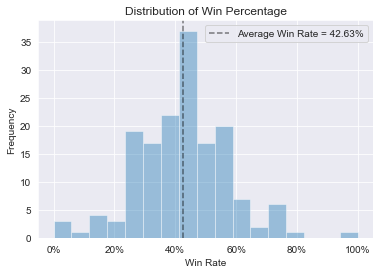

In [2]:
import numpy as np
import seaborn as sns
import scipy
sns.set_style('darkgrid')
%matplotlib inline

p = np.average(result_df['Win %'])
#sns.distplot(result_df['Win %'],bins=np.linspace(0,1,25),kde=False,norm_hist=True,label='Observed Win %')
sns.distplot(result_df['Win %']*100,kde=False)
plt.axvline(np.mean(result_df['Win %']*100),color='k',linestyle='--',alpha=0.5,label='Average Win Rate = '+str(round(np.mean(result_df['Win %']*100),2))+"%")
plt.xlabel('Win Rate')
plt.xticks(np.linspace(0,100,6),['0%','20%','40%','60%','80%','100%'])
plt.ylabel('Frequency')
plt.title('Distribution of Win Percentage')
plt.legend()
#plt.savefig('win_percentage.pdf')
plt.show()

## The total win rate is 42.75%. For companies with all 24 straddles, is the win rate drawn from a binomial distribution?

KS Statistic
KstestResult(statistic=0.20928425063333778, pvalue=0.0023260119767862797)


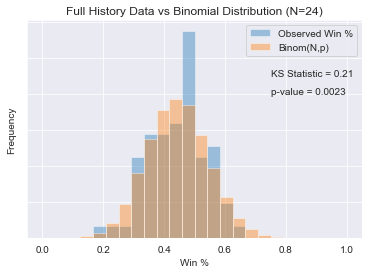

In [3]:
import numpy as np
import seaborn as sns
import scipy
sns.set_style('darkgrid')
%matplotlib inline

# First, get all data with a fixed n and make a histogram
n = 24
data = result_df[result_df['N_straddles']==n]
data.index = range(len(data))
p = np.average(data['Win %'])
sns.distplot(data['Win %'],bins=np.linspace(0,1,25),kde=False,norm_hist=True,label='Observed Win %')

# Next, plot a binomial distribution with n,p
binom_dist = np.random.binomial(n, p, size=100000)
binom_dist = binom_dist/n
sns.distplot(binom_dist,bins=np.linspace(0,1,25),kde=False,norm_hist=True,label='Binom(N,p)')

# Get Kolmogorov-Smirnov Statistic
print("KS Statistic")
KS = scipy.stats.kstest(data['N_wins'],'binom',args=(n,p))
p_value = KS[1]
print(KS)

# Clean up plot
plt.annotate("KS Statistic = 0.21",(0.75,4.5))
plt.annotate("p-value = 0.0023",(0.75,4.0))
plt.yticks(np.arange(7),[])
plt.ylabel('Frequency')
plt.legend()
plt.title('Full History Data vs Binomial Distribution (N=24)')
#plt.savefig('binom.pdf')
plt.show()

## Part II Conclusions
- We can reject the null hypothesis that the observed win % is drawn from a binomial distribution. This means straddle wins are not individually drawn from a bernoulli distribution.
- We still do not know whether the strategy will work better for some companies 

# Part III - What happened last time?
The last time I analyzed pre-earnings straddles I drew 20 companies alphabetically from the S&P 100 and looked at how they performed in 2016. I found that there were -8% returns on average, which appears to differ significantly from the 2% I just calculated. Was this just an unlucky sample?

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
sns.set_style('darkgrid')
%matplotlib inline

# Read in the companies used in the first analysis
v1_companies = pd.read_csv('symbols.csv',names=['Companies'],header=None)
companies = v1_companies['Companies'].tolist()
companies

# Read in data used for second analysis
orig_df = pd.read_csv('all_trades.csv',index_col=0)  # all trades for all companies
new_df = orig_df[orig_df['Year']==2016] # just 2016
df = new_df[new_df['Symbol'].isin(companies)]  # just the companies in version 1
df = df.sort_values('Date') # sort by date
df.index = range(len(df)) # reindex

# Run backtest
open_calls = {}
open_puts = {}
open_straddles = {}  # if you have an open call and open put you have an open straddle
results = {k: [] for k in np.unique(df['Symbol'])} # dict to store the open and close price of all straddles


for i in df.index:
    
    # Open call and store price
    if df['Description'][i] == 'Open 7DaysBeforeEarnings:Long Calls':
        open_calls[df['Symbol'][i]] = df['Trade Price'][i]
#         print(df['Date'][i],":",df['Symbol'][i]," call opened for ",df['Trade Price'][i])
        
        # Did this open the straddle?
        if df['Symbol'][i] in open_puts.keys():
            open_straddles[df['Symbol'][i]] = [open_puts[df['Symbol'][i]] + open_calls[df['Symbol'][i]]]
#             print(df['Date'][i],":",df['Symbol'][i]," STRADDLE OPENED AT ",open_straddles[df['Symbol'][i]][0])
        
#             # Update our capital
#             for strategy in running_capital.keys():
#                 index = len(running_capital[strategy]) # time series index
#                 capital = running_capital[strategy][index-1] # current capital
#                 bet = bets[strategy]
#                 time[strategy].append(df['Date'][i]) # store date
#                 if capital - bet >= 0.:
#                     print("\tBET($) = ",bet,"ON STRATEGY",strategy)
#                     running_capital[strategy].append(round(capital-bet,2))  # subtract cost of bet
#                     open_bets[strategy].append(df['Symbol'][i])
#                 else:
#                     print("\tUNABLE TO AFFORD ",strategy," BET")
#                     running_capital[strategy].append(round(capital,2))
        
    # Open put and store price
    elif df['Description'][i] == 'Open 7DaysBeforeEarnings:Long Puts':
        open_puts[df['Symbol'][i]] = df['Trade Price'][i]
#         print(df['Date'][i],":",df['Symbol'][i]," put opened for ",df['Trade Price'][i])
        
        # Did this open the straddle?
        if df['Symbol'][i] in open_calls.keys():
            open_straddles[df['Symbol'][i]] = [open_puts[df['Symbol'][i]] + open_calls[df['Symbol'][i]]]
#             print(df['Date'][i],":",df['Symbol'][i]," STRADDLE OPENED AT ",open_straddles[df['Symbol'][i]][0])
            
#             # Update our capital
#             for strategy in running_capital.keys():
#                 index = len(running_capital[strategy]) # time series index
#                 capital = running_capital[strategy][index-1] # current capital
#                 bet = bets[strategy]
#                 time[strategy].append(df['Date'][i]) # store date
#                 if capital - bet >= 0.:
#                     print("\tBET($) = ",bet,"ON STRATEGY",strategy)
#                     running_capital[strategy].append(round(capital-bet,2))  # subtract cost of bet
#                     open_bets[strategy].append(df['Symbol'][i])
#                 else:
#                     print("\tUNABLE TO AFFORD ",strategy," BET")
#                     running_capital[strategy].append(round(capital,2))
        
    # Close call and store percent change
    elif df['Description'][i] == 'Close 1DaysBeforeEarnings:Long Calls' or \
    df['Description'][i] == 'Close 40%CloseAfterGains:Long Calls' or \
    df['Description'][i] =='Close -40%CloseAfterLosses:Long Calls':
        closing_price = df['Trade Price'][i]
        opening_price = open_calls[df['Symbol'][i]]
        open_calls.pop(df['Symbol'][i], None) # close call
#         print(df['Date'][i],":",df['Symbol'][i]," call closed for ",df['Trade Price'][i])
        open_straddles[df['Symbol'][i]].append(closing_price-opening_price) # append change in call price to open_straddle
            
        # Did this close the straddle?
        if df['Symbol'][i] not in open_puts.keys():
            opening_price = open_straddles[df['Symbol'][i]][0]
            closing_price = np.sum(open_straddles[df['Symbol'][i]])
            percent_change = (closing_price-opening_price)/opening_price
            results[df['Symbol'][i]].append([opening_price,closing_price])
#             print(df['Date'][i],":",df['Symbol'][i]," STRADDLE CLOSED AT ",closing_price)
#             print("\t GAIN/LOSS(%) = ",percent_change)
            open_straddles.pop(df['Symbol'][i], None) # close straddle
            
#             # Update our capital if we placed the bet
#             for strategy in running_capital.keys():
#                 index = len(running_capital[strategy]) # time series index
#                 capital = running_capital[strategy][index-1] # current capital                
#                 bet = bets[strategy]
#                 if df['Symbol'][i] in open_bets[strategy]:
#                     capital = capital+bet*(1+percent_change) # new capital
#                     open_bets[strategy].remove(df['Symbol'][i]) # close bet 
#                 running_capital[strategy].append(round(capital,2))  # subtract cost of bet
#                 time[strategy].append(df['Date'][i])
                
#             # Lets count how many straddles actually closed when the limit was met vs how many limits were met
#             if percent_change >= 0.4:
#                 N_greater_than_40 = N_greater_than_40 + 1
#             if percent_change <= -0.4:
#                 N_less_than_40 = N_less_than_40 + 1

#             if df['Description'][i] == 'Close 40%CloseAfterGains:Long Calls':
#                 N_max_caught = N_max_caught + 1
#             if df['Description'][i] =='Close -40%CloseAfterLosses:Long Calls':
#                 N_min_caught = N_min_caught + 1        
        
        
    # Close put and store percent change
    elif df['Description'][i] == 'Close 1DaysBeforeEarnings:Long Puts' or \
    df['Description'][i] == 'Close 40%CloseAfterGains:Long Puts' or \
    df['Description'][i] =='Close -40%CloseAfterLosses:Long Puts':
        closing_price = df['Trade Price'][i]
        opening_price = open_puts[df['Symbol'][i]]
        open_straddles[df['Symbol'][i]].append(closing_price-opening_price) # append change in put price to open_straddle
        open_puts.pop(df['Symbol'][i], None) # close put
#         print(df['Date'][i],":",df['Symbol'][i]," put closed for ",df['Trade Price'][i])
        
        # Did this close the straddle?
        if df['Symbol'][i] not in open_calls.keys():
            opening_price = open_straddles[df['Symbol'][i]][0]
            closing_price = np.sum(open_straddles[df['Symbol'][i]])
            percent_change = (closing_price-opening_price)/opening_price
            results[df['Symbol'][i]].append([opening_price,closing_price])
#             print(df['Date'][i],":",df['Symbol'][i]," STRADDLE CLOSED AT ",closing_price)
#             print("\t GAIN/LOSS(%) = ",percent_change)
            open_straddles.pop(df['Symbol'][i], None) # close straddle
            
#             # Update our capital if we placed the bet
#             for strategy in running_capital.keys():
#                 index = len(running_capital[strategy]) # time series index
#                 capital = running_capital[strategy][index-1] # current capital                
#                 bet = bets[strategy]
#                 if df['Symbol'][i] in open_bets[strategy]:
#                     capital = capital+bet*(1+percent_change) # new capital
#                     open_bets[strategy].remove(df['Symbol'][i]) # close bet 
#                 running_capital[strategy].append(round(capital,2))  # subtract cost of bet
#                 time[strategy].append(df['Date'][i])
            
#             # Lets count how many straddles actually closed when the limit was met vs how many limits were met
#             if percent_change >= 0.4:
#                 N_greater_than_40 = N_greater_than_40 + 1
#             if percent_change <= -0.4:
#                 N_less_than_40 = N_less_than_40 + 1

#             if df['Description'][i] == 'Close 40%CloseAfterGains:Long Calls':
#                 N_max_caught = N_max_caught + 1
#             if df['Description'][i] =='Close -40%CloseAfterLosses:Long Calls':
#                 N_min_caught = N_min_caught + 1        
            
    else:
        print("ERROR!!! NO MATCHING DESCRIPTION",df['Description'][i])
        flag = 1
        break
        
# Write the results dict to a file
with open('comparison_results.pkl', 'wb') as fp:
    pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

print("\nBacktest Complete")



Backtest Complete


In [5]:
results.keys()

dict_keys(['AAPL', 'AMGN', 'AMZN', 'AXP', 'BA', 'BIIB', 'BKNG', 'CAT'])

### Calculate average win percentage for results

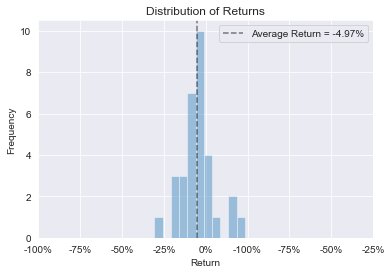

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
sns.set_style('darkgrid')
%matplotlib inline

# Read in the results dict from file
with open('comparison_results.pkl', 'rb') as fp:
    results = pickle.load(fp)    
    
return_percentage = []
for company in results.keys():
    for straddle in results[company]:
        initial_value = straddle[0]
        final_value = straddle[1]
        percent_diff = (final_value-initial_value)/initial_value*100
#         if percent_diff > 40.:
#             percent_diff = 40.
#         if percent_diff < -40:
#             percent_diff = -40
        return_percentage.append(percent_diff)
        
sns.distplot(return_percentage,kde=False)
plt.axvline(np.mean(return_percentage),color='k',linestyle='--',alpha=0.5,label='Average Return = '+str(round(np.mean(return_percentage),2))+"%")
plt.title('Distribution of Returns')
plt.ylabel('Frequency')
plt.xlabel('Return')
plt.xlim((-100,100))
plt.xticks(np.linspace(-100,100,9),['-100%','-75%','-50%','-25%','0%','-100%','-75%','-50%','-25%'])
plt.legend()
#plt.savefig("returns.pdf")
plt.show()

## How anomolous is -8% expected returns on roughly 80 samples under the null hypothesis they were drawn from our expected return distribution?

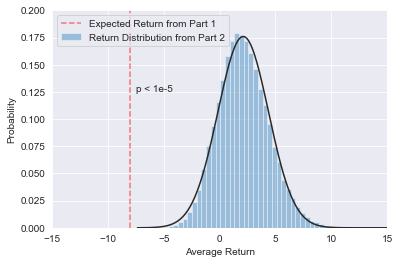

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import scipy
from scipy.stats import norm
sns.set_style('darkgrid')
%matplotlib inline

N_samples = 19*4  # there were actually 19 companies each with 4 straddles
N_trials = 100000 # Number of times to repeat our analysis
result = -8.  # result from part 1

# Read in the results dict from file
with open('straddle_results.pkl', 'rb') as fp:
    results = pickle.load(fp)    
    
return_percentage = []
for company in results.keys():
    for straddle in results[company]:
        initial_value = straddle[0]
        final_value = straddle[1]
        percent_diff = (final_value-initial_value)/initial_value*100
#         if percent_diff > 40.:
#             percent_diff = 40.
#         if percent_diff < -40:
#             percent_diff = -40
        return_percentage.append(percent_diff)
    
return_percentage

x = np.random.choice(return_percentage, size=None, replace=True, p=None)


average_dist = [] # distribution of expected returns
for i in range(N_trials):
    sample = np.random.choice(return_percentage,size=N_samples,replace=True)
    average_dist.append(np.mean(sample))
    
sns.distplot(average_dist,fit=norm,kde=False,label='Return Distribution from Part 2')
plt.axvline(result,linestyle='--',color='red',alpha=0.5,label='Expected Return from Part 1')
plt.legend(loc='best')
plt.xlim((-15,15))
plt.ylim((0,.2))
mean,std_dev = norm.fit(average_dist)
plt.xlabel('Average Return')
plt.ylabel('Probability')
plt.annotate('p < 1e-5',(-7.5,.125))
#plt.savefig('part1.pdf')
plt.show()

#### How many standard deviations away are we?

In [8]:
mean,std_dev = norm.fit(average_dist)
z = (result-mean)/std_dev
print("Z-Score = ",z)

p = scipy.stats.norm.sf(abs(z)) #one-sided
print("1 sided p-value = ",p)
p = scipy.stats.norm.sf(abs(z))*2 #twosided
print("2 sided p-value = ",p)


Z-Score =  -4.461344235657511
1 sided p-value =  4.072356808534964e-06
2 sided p-value =  8.144713617069928e-06


## How anomalous is the data relative to 2016 returns?

In [9]:
import pandas as pd
import numpy as np
import json
import pickle


# Read in data
df = pd.read_csv('all_trades.csv',index_col=0)  # all trades for all companies
df = df[df['Year']==2016]
df.index = range(len(df))

initial_capital = 10e6  # start with 10M
capital = initial_capital
bets = {'1K':1000,'10K':1e4,'100K':1e5,'300K':3e5} # betting strategy
running_capital ={'1K':[capital],'10K':[capital],'100K':[capital],'300K':[capital]} # portfolio value for each strategy
open_bets ={'1K':[],'10K':[],'100K':[],'300K':[]} # holds the open bets for each strategy
time = {'1K':[df['Date'][0]],'10K':[df['Date'][0]],'100K':[df['Date'][0]],'300K':[df['Date'][0]]} # portfolio value for each strategy

# Loop over trades and keep track of money
open_calls = {}
open_puts = {}
open_straddles = {}  # if you have an open call and open put you have an open straddle
results = {k: [] for k in np.unique(df['Symbol'])} # dict to store the open and close price of all straddles

# Run backtest on straddles
print("Starting Backtest...")
print("Initial Capital = $",int(initial_capital))
print("Strategies = ")
for strategy in bets.keys():
    print("\t",strategy,"fixed bet.")
print("\n")

flag = 0 # catch errors
N_greater_than_40 = 0
N_less_than_40 = 0
N_max_caught = 0
N_min_caught = 0
for i in df.index:
    
    # Open call and store price
    if df['Description'][i] == 'Open 7DaysBeforeEarnings:Long Calls':
        open_calls[df['Symbol'][i]] = df['Trade Price'][i]
        print(df['Date'][i],":",df['Symbol'][i]," call opened for ",df['Trade Price'][i])
        
        # Did this open the straddle?
        if df['Symbol'][i] in open_puts.keys():
            open_straddles[df['Symbol'][i]] = [open_puts[df['Symbol'][i]] + open_calls[df['Symbol'][i]]]
            print(df['Date'][i],":",df['Symbol'][i]," STRADDLE OPENED AT ",open_straddles[df['Symbol'][i]][0])
        
            # Update our capital
            for strategy in running_capital.keys():
                index = len(running_capital[strategy]) # time series index
                capital = running_capital[strategy][index-1] # current capital
                bet = bets[strategy]
                time[strategy].append(df['Date'][i]) # store date
                if capital - bet >= 0.:
                    print("\tBET($) = ",bet,"ON STRATEGY",strategy)
                    running_capital[strategy].append(round(capital-bet,2))  # subtract cost of bet
                    open_bets[strategy].append(df['Symbol'][i])
                else:
                    print("\tUNABLE TO AFFORD ",strategy," BET")
                    running_capital[strategy].append(round(capital,2))
        
    # Open put and store price
    elif df['Description'][i] == 'Open 7DaysBeforeEarnings:Long Puts':
        open_puts[df['Symbol'][i]] = df['Trade Price'][i]
        print(df['Date'][i],":",df['Symbol'][i]," put opened for ",df['Trade Price'][i])
        
        # Did this open the straddle?
        if df['Symbol'][i] in open_calls.keys():
            open_straddles[df['Symbol'][i]] = [open_puts[df['Symbol'][i]] + open_calls[df['Symbol'][i]]]
            print(df['Date'][i],":",df['Symbol'][i]," STRADDLE OPENED AT ",open_straddles[df['Symbol'][i]][0])
            
            # Update our capital
            for strategy in running_capital.keys():
                index = len(running_capital[strategy]) # time series index
                capital = running_capital[strategy][index-1] # current capital
                bet = bets[strategy]
                time[strategy].append(df['Date'][i]) # store date
                if capital - bet >= 0.:
                    print("\tBET($) = ",bet,"ON STRATEGY",strategy)
                    running_capital[strategy].append(round(capital-bet,2))  # subtract cost of bet
                    open_bets[strategy].append(df['Symbol'][i])
                else:
                    print("\tUNABLE TO AFFORD ",strategy," BET")
                    running_capital[strategy].append(round(capital,2))
        
    # Close call and store percent change
    elif df['Description'][i] == 'Close 1DaysBeforeEarnings:Long Calls' or \
    df['Description'][i] == 'Close 40%CloseAfterGains:Long Calls' or \
    df['Description'][i] =='Close -40%CloseAfterLosses:Long Calls':
        closing_price = df['Trade Price'][i]
        opening_price = open_calls[df['Symbol'][i]]
        open_calls.pop(df['Symbol'][i], None) # close call
        print(df['Date'][i],":",df['Symbol'][i]," call closed for ",df['Trade Price'][i])
        open_straddles[df['Symbol'][i]].append(closing_price-opening_price) # append change in call price to open_straddle
        
        # Did this close the straddle?
        if df['Symbol'][i] not in open_puts.keys():
            opening_price = open_straddles[df['Symbol'][i]][0]
            closing_price = np.sum(open_straddles[df['Symbol'][i]])
            percent_change = (closing_price-opening_price)/opening_price
            results[df['Symbol'][i]].append([opening_price,closing_price])
            print(df['Date'][i],":",df['Symbol'][i]," STRADDLE CLOSED AT ",closing_price)
            print("\t GAIN/LOSS(%) = ",percent_change)
            open_straddles.pop(df['Symbol'][i], None) # close straddle
            
            # Update our capital if we placed the bet
            for strategy in running_capital.keys():
                index = len(running_capital[strategy]) # time series index
                capital = running_capital[strategy][index-1] # current capital                
                bet = bets[strategy]
                if df['Symbol'][i] in open_bets[strategy]:
                    capital = capital+bet*(1+percent_change) # new capital
                    open_bets[strategy].remove(df['Symbol'][i]) # close bet 
                running_capital[strategy].append(round(capital,2))  # subtract cost of bet
                time[strategy].append(df['Date'][i])
                
            # Lets count how many straddles actually closed when the limit was met vs how many limits were met
            if percent_change >= 0.4:
                N_greater_than_40 = N_greater_than_40 + 1
            if percent_change <= -0.4:
                N_less_than_40 = N_less_than_40 + 1

            if df['Description'][i] == 'Close 40%CloseAfterGains:Long Calls':
                N_max_caught = N_max_caught + 1
            if df['Description'][i] =='Close -40%CloseAfterLosses:Long Calls':
                N_min_caught = N_min_caught + 1        
        
        
    # Close put and store percent change
    elif df['Description'][i] == 'Close 1DaysBeforeEarnings:Long Puts' or \
    df['Description'][i] == 'Close 40%CloseAfterGains:Long Puts' or \
    df['Description'][i] =='Close -40%CloseAfterLosses:Long Puts':
        closing_price = df['Trade Price'][i]
        opening_price = open_puts[df['Symbol'][i]]
        open_straddles[df['Symbol'][i]].append(closing_price-opening_price) # append change in put price to open_straddle
        open_puts.pop(df['Symbol'][i], None) # close put
        print(df['Date'][i],":",df['Symbol'][i]," put closed for ",df['Trade Price'][i])
        
        # Did this close the straddle?
        if df['Symbol'][i] not in open_calls.keys():
            opening_price = open_straddles[df['Symbol'][i]][0]
            closing_price = np.sum(open_straddles[df['Symbol'][i]])
            percent_change = (closing_price-opening_price)/opening_price
            results[df['Symbol'][i]].append([opening_price,closing_price])
            print(df['Date'][i],":",df['Symbol'][i]," STRADDLE CLOSED AT ",closing_price)
            print("\t GAIN/LOSS(%) = ",percent_change)
            open_straddles.pop(df['Symbol'][i], None) # close straddle
            
            # Update our capital if we placed the bet
            for strategy in running_capital.keys():
                index = len(running_capital[strategy]) # time series index
                capital = running_capital[strategy][index-1] # current capital                
                bet = bets[strategy]
                if df['Symbol'][i] in open_bets[strategy]:
                    capital = capital+bet*(1+percent_change) # new capital
                    open_bets[strategy].remove(df['Symbol'][i]) # close bet 
                running_capital[strategy].append(round(capital,2))  # subtract cost of bet
                time[strategy].append(df['Date'][i])
            
            # Lets count how many straddles actually closed when the limit was met vs how many limits were met
            if percent_change >= 0.4:
                N_greater_than_40 = N_greater_than_40 + 1
            if percent_change <= -0.4:
                N_less_than_40 = N_less_than_40 + 1

            if df['Description'][i] == 'Close 40%CloseAfterGains:Long Calls':
                N_max_caught = N_max_caught + 1
            if df['Description'][i] =='Close -40%CloseAfterLosses:Long Calls':
                N_min_caught = N_min_caught + 1        
            
    else:
        print("ERROR!!! NO MATCHING DESCRIPTION",df['Description'][i])
        flag = 1
        break


# Write the results dict to a file
with open('straddle_results.pkl', 'wb') as fp:
    pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Write the time series to a json
ts_df = pd.DataFrame(
    {
        'Date':time['1K'],
        '1K':running_capital['1K'],
        '10K':running_capital['10K'],
        '100K':running_capital['100K'],
        '300K':running_capital['300K']
    }
)

# Set negative value to zeros
pd.options.mode.chained_assignment = None  # turn off warning about chained assignments
for column in ts_df.columns[1:]:
    array = ts_df[column]
    for i in array.index:
        if ts_df[column][i] < 0:
            print("Portfolio went negative for ",column," strategy")
            ts_df[column][i:] = 0.
            break
            
ts_df.to_pickle('time_series.pkl')  # save dataframe as pickle
    
if flag == 0:
    print("\nBacktest Complete")
    for strategy in running_capital.keys():
        print("Strategy = ",strategy," Fixed Bet")
        print("\tInitial Capital = ",initial_capital)
        final_capital = ts_df[strategy].iloc[-1]
        print("\tFinal Capital = ",final_capital)
        print("\tPercent Change = ",round((final_capital-initial_capital)/initial_capital,6)*100,"%")


Starting Backtest...
Initial Capital = $ 10000000
Strategies = 
	 1K fixed bet.
	 10K fixed bet.
	 100K fixed bet.
	 300K fixed bet.


2016-01-05 : CSX  put opened for  0.97
2016-01-05 : CSX  call opened for  0.47
2016-01-05 : CSX  STRADDLE OPENED AT  1.44
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-01-07 : INTC  put opened for  0.84
2016-01-07 : JPM  put opened for  1.64
2016-01-07 : JPM  call opened for  1.46
2016-01-07 : JPM  STRADDLE OPENED AT  3.0999999999999996
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-01-07 : CSX  call closed for  0.11
2016-01-07 : CSX  put closed for  2.47
2016-01-07 : CSX  STRADDLE CLOSED AT  2.58
	 GAIN/LOSS(%) =  0.7916666666666667
2016-01-07 : INTC  call opened for  0.8
2016-01-07 : INTC  STRADDLE OPENED AT  1.6400000000000001
	BET($) =  1000 ON STRATEGY 1K

2016-01-21 : CHKP  STRADDLE OPENED AT  5.95
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-01-21 : GE  call closed for  0.44
2016-01-21 : GE  STRADDLE CLOSED AT  0.7299999999999998
	 GAIN/LOSS(%) =  -0.3047619047619049
2016-01-21 : MSFT  put opened for  1.8
2016-01-21 : MSFT  call opened for  1.86
2016-01-21 : MSFT  STRADDLE OPENED AT  3.66
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-01-21 : V  put opened for  1.71
2016-01-21 : V  STRADDLE OPENED AT  3.58
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-01-21 : AMZN  put opened for  29.2
2016-01-21 : SWKS  call opened for  2.72
2016-01-21 : WDC  put opened for  1.82
2016-01-21 : WDC  call opened for  1.96
2016-01-21 : WDC  STRADDLE OPENED AT  3.7

2016-01-26 : QCOM  STRADDLE CLOSED AT  3.73
	 GAIN/LOSS(%) =  -0.03367875647668391
2016-01-26 : BIIB  put closed for  14.35
2016-01-26 : BIIB  STRADDLE CLOSED AT  18.949999999999996
	 GAIN/LOSS(%) =  -0.09976247030878868
2016-01-26 : CTXS  put closed for  3.3
2016-01-26 : CTXS  STRADDLE CLOSED AT  7.250000000000001
	 GAIN/LOSS(%) =  -0.05228758169934633
2016-01-27 : MCHP  put opened for  2.17
2016-01-27 : MRK  call opened for  0.86
2016-01-27 : WDC  call closed for  1.56
2016-01-27 : ADP  put opened for  1.78
2016-01-27 : NXPI  put opened for  3.4
2016-01-27 : ADP  call opened for  2.15
2016-01-27 : ADP  STRADDLE OPENED AT  3.9299999999999997
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-01-27 : AMZN  call closed for  27.4
2016-01-27 : AMZN  put closed for  24.02
2016-01-27 : AMZN  STRADDLE CLOSED AT  51.42
	 GAIN/LOSS(%) =  -0.06475081847944711
2016-01-27 : CELG  put closed for  4.97
201

2016-02-05 : XRAY  STRADDLE OPENED AT  2.45
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-02-05 : FOXA  put closed for  2.17
2016-02-05 : CTSH  call closed for  0.55
2016-02-05 : FOX  call closed for  0.22
2016-02-05 : CTSH  put closed for  4.6
2016-02-05 : CTSH  STRADDLE CLOSED AT  5.15
	 GAIN/LOSS(%) =  0.2875000000000001
2016-02-05 : FOX  put closed for  2.1
2016-02-05 : FOX  STRADDLE CLOSED AT  2.3200000000000003
	 GAIN/LOSS(%) =  0.34883720930232576
2016-02-05 : ATVI  put closed for  3.22
2016-02-05 : ATVI  call closed for  0.72
2016-02-05 : ATVI  STRADDLE CLOSED AT  3.9400000000000004
	 GAIN/LOSS(%) =  0.44322344322344337
2016-02-05 : HAS  put closed for  3.35
2016-02-05 : HAS  call closed for  2.8
2016-02-05 : HAS  STRADDLE CLOSED AT  6.15
	 GAIN/LOSS(%) =  0.1781609195402298
2016-02-05 : FOXA  call closed for  0.2
2016-02-05 : FOXA  STRADDLE CLOSED AT  2.3699999999999997
	 GAIN/LO

2016-02-16 : CERN  STRADDLE CLOSED AT  4.000000000000001
	 GAIN/LOSS(%) =  -0.09090909090909079
2016-02-16 : BKNG  put closed for  15.5
2016-02-16 : NCLH  put opened for  2.45
2016-02-16 : NVDA  call closed for  2.19
2016-02-16 : BKNG  call closed for  84.75
2016-02-16 : BKNG  STRADDLE CLOSED AT  100.25000000000001
	 GAIN/LOSS(%) =  -0.08987743985474345
2016-02-16 : NCLH  call opened for  3.03
2016-02-16 : NCLH  STRADDLE OPENED AT  5.48
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-02-16 : TMUS  call closed for  2.46
2016-02-16 : NVDA  put closed for  0.69
2016-02-16 : NVDA  STRADDLE CLOSED AT  2.88
	 GAIN/LOSS(%) =  -0.02040816326530614
2016-02-16 : TMUS  put closed for  0.45
2016-02-16 : TMUS  STRADDLE CLOSED AT  2.9099999999999997
	 GAIN/LOSS(%) =  0.19753086419753088
2016-02-17 : DISH  call closed for  3.82
2016-02-17 : DISH  put closed for  0.22
2016-02-17 : DISH  STRADDLE CLOSED AT 

	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-03-15 : CTAS  put opened for  2.48
2016-03-15 : CTAS  STRADDLE OPENED AT  4.5600000000000005
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-03-16 : ADBE  put closed for  1.16
2016-03-16 : ADBE  call closed for  4.28
2016-03-16 : ADBE  STRADDLE CLOSED AT  5.44
	 GAIN/LOSS(%) =  -0.003663003663003585
2016-03-21 : CTAS  put closed for  1.98
2016-03-21 : NKE  call closed for  3.95
2016-03-21 : CTAS  call closed for  2.22
2016-03-21 : CTAS  STRADDLE CLOSED AT  4.200000000000001
	 GAIN/LOSS(%) =  -0.0789473684210525
2016-03-21 : NKE  put closed for  0.74
2016-03-21 : NKE  STRADDLE CLOSED AT  4.6899999999999995
	 GAIN/LOSS(%) =  0.371345029239766
2016-03-23 : PAYX  call opened for  0.68
2016-03-23 : MU  put opened for  0.46
2016-03-23 : MU  call opened for  0.62
2016-03-23 : MU  STRAD

2016-04-18 : JNJ  call closed for  1.77
2016-04-18 : JNJ  STRADDLE CLOSED AT  2.6500000000000004
	 GAIN/LOSS(%) =  -0.0893470790378006
2016-04-18 : INTC  put closed for  0.86
2016-04-18 : INTC  STRADDLE CLOSED AT  1.36
	 GAIN/LOSS(%) =  -0.17073170731707318
2016-04-18 : GS  call closed for  5.25
2016-04-18 : GS  STRADDLE CLOSED AT  6.5
	 GAIN/LOSS(%) =  -0.012158054711246211
2016-04-18 : UNH  call closed for  2.19
2016-04-18 : NXPI  put opened for  3.55
2016-04-18 : NXPI  STRADDLE OPENED AT  6.65
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-04-18 : ISRG  call closed for  16.4
2016-04-18 : ISRG  put closed for  19.9
2016-04-18 : ISRG  STRADDLE CLOSED AT  36.3
	 GAIN/LOSS(%) =  -0.06803594351733006
2016-04-18 : UNH  put closed for  1.58
2016-04-18 : UNH  STRADDLE CLOSED AT  3.77
	 GAIN/LOSS(%) =  -0.1944444444444444
2016-04-18 : ESRX  call opened for  1.68
2016-04-18 : ESRX  put opened for

	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-04-21 : CHTR  put opened for  8.9
2016-04-21 : AAL  call closed for  0.34
2016-04-21 : AAL  STRADDLE CLOSED AT  1.7199999999999998
	 GAIN/LOSS(%) =  -0.04444444444444449
2016-04-21 : AMGN  call opened for  2.56
2016-04-21 : CELG  put opened for  2.3
2016-04-21 : GE  put closed for  0.33
2016-04-21 : BMRN  call opened for  3.6
2016-04-21 : BMRN  put opened for  7.65
2016-04-21 : BMRN  STRADDLE OPENED AT  11.25
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-04-21 : GILD  put opened for  2.23
2016-04-21 : VIAB  put opened for  1.5
2016-04-21 : WDC  put opened for  1.93
2016-04-21 : WDC  STRADDLE OPENED AT  3.73
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2

2016-04-27 : BMRN  STRADDLE CLOSED AT  10.93
	 GAIN/LOSS(%) =  -0.02844444444444447
2016-04-27 : MCHP  put opened for  1.45
2016-04-27 : GILD  put closed for  2.6
2016-04-27 : GILD  call closed for  1.29
2016-04-27 : GILD  STRADDLE CLOSED AT  3.89
	 GAIN/LOSS(%) =  -0.08685446009389663
2016-04-27 : AMZN  call closed for  11.18
2016-04-27 : AMZN  put closed for  39.95
2016-04-27 : AMZN  STRADDLE CLOSED AT  51.13
	 GAIN/LOSS(%) =  -0.011598685482311896
2016-04-27 : MCHP  call opened for  1.6
2016-04-27 : MCHP  STRADDLE OPENED AT  3.05
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-04-28 : STX  put closed for  0.15
2016-04-28 : FISV  put opened for  3.12
2016-04-28 : SHPG  put closed for  6.4
2016-04-28 : FISV  call opened for  1.48
2016-04-28 : FISV  STRADDLE OPENED AT  4.6
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  30000

	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-05-05 : SYMC  call opened for  0.54
2016-05-05 : SYMC  put opened for  0.45
2016-05-05 : SYMC  STRADDLE OPENED AT  0.99
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-05-05 : XRAY  call closed for  1.72
2016-05-05 : XRAY  STRADDLE CLOSED AT  2.84
	 GAIN/LOSS(%) =  -0.003508771929824642
2016-05-05 : CTSH  call closed for  1.15
2016-05-05 : CTSH  STRADDLE CLOSED AT  3.25
	 GAIN/LOSS(%) =  -0.09217877094972068
2016-05-06 : QRTEA  call closed for  0.28
2016-05-06 : QRTEA  put closed for  1.23
2016-05-06 : QRTEA  STRADDLE CLOSED AT  1.5100000000000002
	 GAIN/LOSS(%) =  0.027210884353741673
2016-05-06 : JD  put closed for  1.5
2016-05-06 : LILAK  put closed for  1.98
2016-05-06 : LBTYA  call closed for  0.9
2016-05-06 : LBTYK  put closed for  3.95
2016-05-06 : LILAK  call closed for  2.2
2016-05-06 : LILAK  STRADDLE C

2016-06-29 : WBA  call opened for  2.03
2016-06-29 : WBA  STRADDLE OPENED AT  4.31
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-07-05 : WBA  put closed for  2.08
2016-07-05 : FAST  call opened for  1.35
2016-07-05 : FAST  put opened for  1.02
2016-07-05 : FAST  STRADDLE OPENED AT  2.37
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-07-05 : WBA  call closed for  2.05
2016-07-05 : WBA  STRADDLE CLOSED AT  4.129999999999999
	 GAIN/LOSS(%) =  -0.04176334106728553
2016-07-06 : CSX  put opened for  0.62
2016-07-06 : CSX  call opened for  0.58
2016-07-06 : CSX  STRADDLE OPENED AT  1.2
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-07-07 : JPM  put opened for  1.14
2016-07-07 : JPM  call opened for  1.1

2016-07-18 : GS  put closed for  0.64
2016-07-18 : GS  STRADDLE CLOSED AT  7.120000000000001
	 GAIN/LOSS(%) =  0.14653784219001612
2016-07-18 : GILD  call opened for  2.12
2016-07-18 : GILD  put opened for  2.2
2016-07-18 : GILD  STRADDLE OPENED AT  4.32
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-07-18 : MSFT  call closed for  1.44
2016-07-18 : MSFT  STRADDLE CLOSED AT  2.42
	 GAIN/LOSS(%) =  -0.039682539682539715
2016-07-18 : ESRX  put opened for  1.64
2016-07-18 : ESRX  call opened for  1.31
2016-07-18 : ESRX  STRADDLE OPENED AT  2.95
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-07-18 : TXN  call opened for  1.05
2016-07-18 : TXN  put opened for  1.62
2016-07-18 : TXN  STRADDLE OPENED AT  2.67
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRA

	BET($) =  300000.0 ON STRATEGY 300K
2016-07-20 : MXIM  call closed for  1.32
2016-07-20 : MXIM  put closed for  1.27
2016-07-20 : MXIM  STRADDLE CLOSED AT  2.59
	 GAIN/LOSS(%) =  -0.047794117647058786
2016-07-21 : AAL  call closed for  0.38
2016-07-21 : SBAC  put opened for  2.42
2016-07-21 : SBAC  call opened for  4.25
2016-07-21 : SBAC  STRADDLE OPENED AT  6.67
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-07-21 : BIDU  call opened for  5.85
2016-07-21 : GOOGL  put opened for  18.6
2016-07-21 : CELG  put opened for  2.44
2016-07-21 : ALXN  put opened for  4.45
2016-07-21 : GOOG  call opened for  17.1
2016-07-21 : GOOG  put opened for  18.35
2016-07-21 : GOOG  STRADDLE OPENED AT  35.45
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-07-21 : WDC  put opened for  1.89
2016-07-21 : WDC  call op

2016-07-27 : TRIP  STRADDLE OPENED AT  6.47
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-07-27 : GOOGL  put closed for  15.3
2016-07-27 : GOOGL  STRADDLE CLOSED AT  36.650000000000006
	 GAIN/LOSS(%) =  0.008253094910591589
2016-07-27 : SBAC  call closed for  4.75
2016-07-27 : AMZN  call closed for  20.98
2016-07-27 : AMZN  put closed for  32.4
2016-07-27 : AMZN  STRADDLE CLOSED AT  53.38
	 GAIN/LOSS(%) =  -0.055722625154785044
2016-07-27 : FOX  put opened for  0.57
2016-07-27 : FOX  STRADDLE OPENED AT  1.5699999999999998
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-07-27 : BIDU  call closed for  6.78
2016-07-27 : KLAC  put closed for  2.4
2016-07-27 : KLAC  call closed for  2.9
2016-07-27 : KLAC  STRADDLE CLOSED AT  5.3
	 GAIN/LOSS(%) =  0.2529550827423169
2016-07-27 : SBAC  put closed for

2016-08-03 : BKNG  STRADDLE CLOSED AT  85.1
	 GAIN/LOSS(%) =  -0.18486590038314185
2016-08-03 : HSIC  call closed for  3.02
2016-08-03 : HSIC  STRADDLE CLOSED AT  6.4
	 GAIN/LOSS(%) =  -0.07913669064748198
2016-08-03 : LBTYK  call closed for  1.85
2016-08-03 : LBTYK  STRADDLE CLOSED AT  2.25
	 GAIN/LOSS(%) =  0.08173076923076919
2016-08-03 : LBTYA  put closed for  1.0
2016-08-03 : LBTYA  STRADDLE CLOSED AT  1.9499999999999997
	 GAIN/LOSS(%) =  -0.20408163265306126
2016-08-04 : XRAY  call closed for  0.75
2016-08-04 : CTSH  put closed for  0.9
2016-08-04 : CTSH  call closed for  2.25
2016-08-04 : CTSH  STRADDLE CLOSED AT  3.15
	 GAIN/LOSS(%) =  -0.0031645569620253893
2016-08-04 : QRTEA  call closed for  0.43
2016-08-04 : QRTEA  put closed for  1.15
2016-08-04 : QRTEA  STRADDLE CLOSED AT  1.5799999999999998
	 GAIN/LOSS(%) =  0.12857142857142853
2016-08-04 : NVDA  call opened for  2.59
2016-08-04 : NVDA  put opened for  2.8
2016-08-04 : NVDA  STRADDLE OPENED AT  5.39
	BET($) =  1000 ON ST

2016-10-11 : CSX  put closed for  0.96
2016-10-11 : ISRG  put opened for  19.8
2016-10-11 : ISRG  call opened for  17.7
2016-10-11 : ISRG  STRADDLE OPENED AT  37.5
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-10-11 : GS  put opened for  3.52
2016-10-11 : GS  call opened for  2.58
2016-10-11 : GS  STRADDLE OPENED AT  6.1
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-10-11 : UNH  call opened for  2.26
2016-10-11 : INTC  call opened for  0.68
2016-10-11 : INTC  put opened for  0.9
2016-10-11 : INTC  STRADDLE OPENED AT  1.58
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-10-11 : JNJ  put opened for  1.56
2016-10-11 : JNJ  call opened for  1.22
2016-10-11 : JNJ  STRADDLE OPENED AT  2.780000000000000

	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-10-19 : MXIM  call closed for  1.52
2016-10-19 : KLAC  put closed for  1.72
2016-10-19 : MSFT  call closed for  1.62
2016-10-19 : CMCSA  call opened for  1.06
2016-10-19 : TRV  call closed for  2.2
2016-10-19 : CMCSA  put opened for  1.2
2016-10-19 : CMCSA  STRADDLE OPENED AT  2.26
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-10-19 : KLAC  call closed for  1.27
2016-10-19 : KLAC  STRADDLE CLOSED AT  2.99
	 GAIN/LOSS(%) =  -0.20689655172413798
2016-10-19 : BA  put opened for  2.33
2016-10-19 : MXIM  put closed for  0.38
2016-10-19 : MXIM  STRADDLE CLOSED AT  1.9
	 GAIN/LOSS(%) =  -0.010416666666666676
2016-10-19 : AAL  put closed for  0.29
2016-10-19 : AAL  call closed for  1.42
2016-10-19 : AAL  STRADDLE CLOSED AT  1.71
	 GAIN/LOSS(%) =  -0.18181818181818177
2016-10-19 : MSFT

2016-10-25 : EA  call opened for  2.58
2016-10-25 : EA  STRADDLE OPENED AT  5.66
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-10-25 : GILD  put opened for  1.8
2016-10-25 : SBAC  call opened for  2.98
2016-10-25 : SBAC  put opened for  2.85
2016-10-25 : SBAC  STRADDLE OPENED AT  5.83
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-10-25 : CMCSA  put closed for  1.18
2016-10-25 : CMCSA  STRADDLE CLOSED AT  1.8999999999999997
	 GAIN/LOSS(%) =  -0.15929203539823014
2016-10-25 : ILMN  call opened for  4.2
2016-10-25 : ILMN  put opened for  5.05
2016-10-25 : ILMN  STRADDLE OPENED AT  9.25
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-10-25 : PFE  call opened for  0.3
2016-10-25 : PFE  STRADDLE OPENED

2016-11-02 : MNST  put closed for  4.25
2016-11-02 : SYMC  put closed for  0.52
2016-11-02 : MNST  call closed for  4.8
2016-11-02 : MNST  STRADDLE CLOSED AT  9.05
	 GAIN/LOSS(%) =  0.0
2016-11-02 : SYMC  call closed for  0.76
2016-11-02 : SYMC  STRADDLE CLOSED AT  1.2800000000000002
	 GAIN/LOSS(%) =  -0.0656934306569342
2016-11-02 : VIAB  put opened for  1.3
2016-11-02 : VIAB  call opened for  1.1
2016-11-02 : VIAB  STRADDLE OPENED AT  2.4000000000000004
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-11-02 : XRAY  call closed for  5.45
2016-11-02 : XRAY  STRADDLE CLOSED AT  6.25
	 GAIN/LOSS(%) =  0.46713615023474186
2016-11-02 : NTES  put opened for  10.35
2016-11-02 : NTES  STRADDLE OPENED AT  18.4
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2016-11-02 : NCLH  call opened for  1.52
2016-11-02 

2016-12-21 : CTAS  call closed for  2.98
2016-12-21 : CTAS  STRADDLE CLOSED AT  6.330000000000001
	 GAIN/LOSS(%) =  -0.033587786259541945
2016-12-29 : WBA  call opened for  1.78
2016-12-29 : WBA  put opened for  1.83
2016-12-29 : WBA  STRADDLE OPENED AT  3.6100000000000003
	BET($) =  1000 ON STRATEGY 1K
	BET($) =  10000.0 ON STRATEGY 10K
	BET($) =  100000.0 ON STRATEGY 100K
	BET($) =  300000.0 ON STRATEGY 300K
2017-01-04 : WBA  call closed for  1.38
2017-01-04 : WBA  put closed for  1.84
2017-01-04 : WBA  STRADDLE CLOSED AT  3.2199999999999998
	 GAIN/LOSS(%) =  -0.10803324099723007

Backtest Complete
Strategy =  1K  Fixed Bet
	Initial Capital =  10000000.0
	Final Capital =  9995093.57
	Percent Change =  -0.0491 %
Strategy =  10K  Fixed Bet
	Initial Capital =  10000000.0
	Final Capital =  9950935.52
	Percent Change =  -0.4906 %
Strategy =  100K  Fixed Bet
	Initial Capital =  10000000.0
	Final Capital =  9509354.55
	Percent Change =  -4.906499999999999 %
Strategy =  300K  Fixed Bet
	Init

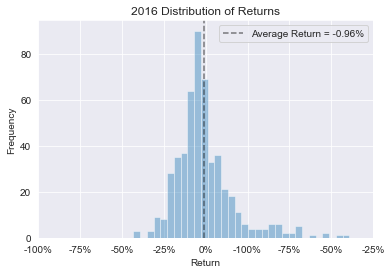

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
sns.set_style('darkgrid')
%matplotlib inline

# Read in the results dict from file
with open('straddle_results.pkl', 'rb') as fp:
    results = pickle.load(fp)    
    
return_percentage = []
for company in results.keys():
    for straddle in results[company]:
        initial_value = straddle[0]
        final_value = straddle[1]
        percent_diff = (final_value-initial_value)/initial_value*100
#         if percent_diff > 40.:
#             percent_diff = 40.
#         if percent_diff < -40:
#             percent_diff = -40
        return_percentage.append(percent_diff)
        
sns.distplot(return_percentage,kde=False)
plt.axvline(np.mean(return_percentage),color='k',linestyle='--',alpha=0.5,label='Average Return = '+str(round(np.mean(return_percentage),2))+"%")
plt.title('2016 Distribution of Returns')
plt.ylabel('Frequency')
plt.xlabel('Return')
plt.xlim((-100,100))
plt.xticks(np.linspace(-100,100,9),['-100%','-75%','-50%','-25%','0%','-100%','-75%','-50%','-25%'])
plt.legend()
#plt.savefig("returns.pdf")
plt.show()

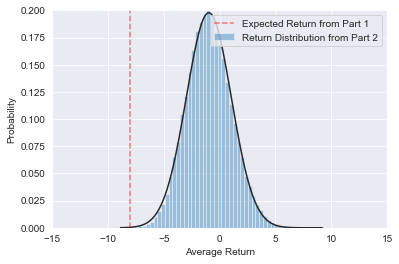

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import scipy
from scipy.stats import norm
sns.set_style('darkgrid')
%matplotlib inline

N_samples = 19*4  # there were actually 19 companies each with 4 straddles
N_trials = 100000 # Number of times to repeat our analysis
result = -8.  # result from part 1

# Read in the results dict from file
with open('straddle_results.pkl', 'rb') as fp:
    results = pickle.load(fp)    
    
return_percentage = []
for company in results.keys():
    for straddle in results[company]:
        initial_value = straddle[0]
        final_value = straddle[1]
        percent_diff = (final_value-initial_value)/initial_value*100
#         if percent_diff > 40.:
#             percent_diff = 40.
#         if percent_diff < -40:
#             percent_diff = -40
        return_percentage.append(percent_diff)
    
return_percentage

x = np.random.choice(return_percentage, size=None, replace=True, p=None)


average_dist = [] # distribution of expected returns
for i in range(N_trials):
    sample = np.random.choice(return_percentage,size=N_samples,replace=True)
    average_dist.append(np.mean(sample))
    
sns.distplot(average_dist,fit=norm,kde=False,label='Return Distribution from Part 2')
plt.axvline(result,linestyle='--',color='red',alpha=0.5,label='Expected Return from Part 1')
plt.legend(loc='best')
plt.xlim((-15,15))
plt.ylim((0,.2))
mean,std_dev = norm.fit(average_dist)
plt.xlabel('Average Return')
plt.ylabel('Probability')
# plt.annotate('p < 1e-5',(-7.5,.125))
#plt.savefig('part1_2016.pdf')
plt.show()

In [12]:
mean,std_dev = norm.fit(average_dist)
z = (result-mean)/std_dev
print("Z-Score = ",z)

p = scipy.stats.norm.sf(abs(z)) #one-sided
print("1 sided p-value = ",p)
p = scipy.stats.norm.sf(abs(z))*2 #twosided
print("2 sided p-value = ",p)

Z-Score =  -3.4869320012789227
1 sided p-value =  0.00024429778454328714
2 sided p-value =  0.0004885955690865743


## Part III Results
- 2016 was indeed a bad year, but not bad enough to explain -8% returns
- The companies tested the first time around from the S&P 100 act differently under pre-earnings straddles than those from the DJI/NDX index.